# Introduction
We hope you're reading this on <font color = "orange">Google Colab</font>. If not, go back to Part III and follow the guide! 

In this section, we will:
1. Mount the Google Drive and read the CSV
2. Train a vanilla LSTM model using Open
3. Train another vanilla LSTM model using FilteredOpen
4. Plot and compare our model results

As mentioned at the end of Part I, we will be answering two questions:
1. Can LSTM help with stock predictions?
2. Can using signal processing technique help with improving stock predictions?

### Step 1: Import pandas
Let's start with importing pandas.

In [ ]:
# Step 1: Import pandas

In [186]:
import pandas as pd

### Step 2: Mount your drive
Before we can read the CSV we'll need to mount the drive.

![MountDriveInstructions](https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectFinancexLSTM/MountDriveInstructions.png)

Steps you'll need:
1. Connect the runtime
2. Mount your Google Drive
3. Navigate through your directory until you reach the folder containing "Project Finance x LSTM (Part IV).ipynb" and the CSV from Part III
4. [Not shown] Right click, and click 'Copy path'
5. Use that to read your CSV using pandas later

In [ ]:
# Step 2: Click on 'Mount Drive' button (2) and mount drive

In [187]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Step 3: Read the CSV from Part III
Now that you've mounted the Drive, you can now read the CSV that you've uploaded into the Google Drive.

Make sure you set the first column as your index, and parse dates so that the dates are parsed as DateTimeIndex object.

You should have:
- 4,904 rows
- 7 columns

In [ ]:
# Step 3: Read the CSV from Part III

In [188]:
sp500=pd.read_csv("/content/drive/My Drive/Stock_Price_Prediction/sp500_Filtered_open.csv",index_col='Date',parse_dates=True)


In [189]:
sp500

,Open,High,Low,Close,Adj Close,Volume,FilteredOpen
Date,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,1509.891113
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1460.423078
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1438.658516
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1386.279016
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1399.262688
...,...,...,...,...,...,...,...
2019-06-25,2945.780029,2946.520020,2916.010010,2917.379883,2917.379883,3578050000,2911.075968
2019-06-26,2926.070068,2932.590088,2912.989990,2913.780029,2913.780029,3478130000,2913.774021
2019-06-27,2919.659912,2929.300049,2918.570068,2924.919922,2924.919922,3122920000,2913.647693


### Step 4: Import libraries
Now, we import the rest of the libraries needed for LSTM model training. Here are the libraries you'll need:
- matplotlib.pyplot as plt
- numpy as np
- StandardScaler from sklearn.preprocessing
- mean_squared_error from sklearn.metrics
- Sequential from keras.models
- Dense from keras.layers
- LSTM from keras.layers
- Dropout from keras.layers

In [ ]:
# Step 4: Import libraries

In [190]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout



### Step 5: Split your data into train and test
Similarly, split your DataFrame into train and test DataFrames according to the following dates:

- Train data: January 3 2000 to May 16 2019
- Test data: May 15 2019 to July 1 2019

You might be wondering why there's an overlap between the last 2 days and first 2 days of Train and Test respectively. 

We'll explain a bit more later.

In [ ]:
# Step 5: Split DataFrame into train and test

In [191]:
train=sp500['2000-01-03' :'2019-05-16']
test=sp500['2019-05-15' :'2019-07-01']

# Data Preparation
We'll have to do a bit more data preparation before we start training our model.

This step was not mentioned in the publication, but it's good practice to scale your values. 

We'll prepare three separate sets of scaled training data:
1. Open
2. FilteredOpen
3. ZeroMeanFilteredOpen (we'll get to that soon)

### Step 6: Add a new column called ZeroMeanFilteredOpen
![ResearchPaperNormalization](https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectFinancexLSTM/ResearchPaperNormalization.png)

In the paper, the authors performed zero-mean normalization. What is zero-mean normalization?

![ZeroMeanNormalization](https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectFinancexLSTM/ZeroMeanNormalization.png)

Zero-mean normalization happens when you subtract all values in a column with the overall mean. 

We will do the same with our denoised Open data and name the new column 'ZeroMeanFilteredOpen'.

Here's what we'll do:
1. Create a new column 'ZeroMeanFilteredOpen' in the train DataFrame, using the mean of 'FilteredOpen' in train
2. Create a new column 'ZeroMeanFilteredOpen' in the test DataFrame, using the mean of 'FilteredOpen' in train

It's not the usual normalization, but we should still normalize after splitting, and using data from train set only.

In [ ]:
# Step 6a: Get the mean of 'FilteredOpen' from train

# Step 6b: Create 'ZeroMeanFilteredOpen' in train

# Step 6c: Create 'ZeroMeanFilteredOpen' in test

In [192]:
mean_FilteredOpen=train['FilteredOpen'].mean()

In [193]:
mean_FilteredOpen

1528.9837666615056

In [194]:
type(mean_FilteredOpen)

float

In [195]:
train['ZeroMeanFilteredOpen']=train['FilteredOpen'].subtract(mean_FilteredOpen) 
train

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Open,High,Low,Close,Adj Close,Volume,FilteredOpen,ZeroMeanFilteredOpen
Date,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,1509.891113,-19.092654
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1460.423078,-68.560689
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1438.658516,-90.325251
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1386.279016,-142.704751
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1399.262688,-129.721079
...,...,...,...,...,...,...,...,...
2019-05-10,2863.100098,2891.310059,2825.389893,2881.399902,2881.399902,3529600000,2871.153391,1342.169625
2019-05-13,2840.189941,2840.189941,2801.429932,2811.870117,2811.870117,3894030000,2856.303768,1327.320001
2019-05-14,2820.120117,2852.540039,2820.120117,2834.409912,2834.409912,3322720000,2844.617713,1315.633947


In [196]:
test['ZeroMeanFilteredOpen']=test['FilteredOpen'].subtract(mean_FilteredOpen) 
test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Open,High,Low,Close,Adj Close,Volume,FilteredOpen,ZeroMeanFilteredOpen
Date,,,,,,,,
2019-05-15,2820.379883,2858.679932,2815.080078,2850.959961,2850.959961,3125950000,2840.351719,1311.367953
2019-05-16,2855.800049,2892.149902,2855.800049,2876.320068,2876.320068,3338060000,2839.855921,1310.872155
2019-05-17,2858.600098,2885.479980,2854.229980,2859.530029,2859.530029,3257950000,2839.645614,1310.661848
2019-05-20,2841.939941,2853.860107,2831.290039,2840.229980,2840.229980,3288870000,2838.708026,1309.724259
2019-05-21,2854.020020,2868.879883,2854.020020,2864.360107,2864.360107,3218700000,2834.590995,1305.607228
2019-05-22,2856.060059,2865.469971,2851.110107,2856.270020,2856.270020,3192510000,2828.357791,1299.374024
2019-05-23,2836.699951,2836.699951,2805.489990,2822.239990,2822.239990,3891980000,2822.287244,1293.303477
2019-05-24,2832.409912,2841.360107,2820.189941,2826.060059,2826.060059,2887390000,2814.062342,1285.078576
2019-05-28,2830.030029,2840.510010,2801.580078,2802.389893,2802.389893,4121410000,2801.668160,1272.684393


### Step 7: Transform Open, FilteredOpen, and ZeroMeanFilteredOpen with StandardScaler
After creating ZeroMeanFilteredOpen, we'll proceed with feature scaling. 

This step was not mentioned in the paper, but it's good practice to do so for training. 

First, let's declare three variables containing a StandardScaler, without any additional parameters. 

We can't use the same scaler for the three Opens because we'll be using the scaler to un-scale predictions as well so the scaler properties must be specific to each Open data.

Then, we'll scale our column values and use that for training.

Note: If you have an error that goes <strong>"Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample."</strong>, you used a Series. 

Either use a DataFrame containing only the Open/FilteredOpen/ZeroMeanFilteredOpen column, or a (-1, 1) reshape to reshape your the np.array of your Series.

In [ ]:
# Step 7a: Declare a StandardScaler for Open

# Step 7b: Call .fit_transform on the 'Open' column values from your train dataset


# Step 7c: Declare a StandardScaler for FilteredOpen

# Step 7d: Call .fit_transform on the 'FilteredOpen' column values from your train dataset


# Step 7e: Declare a StandardScaler for ZeroMeanFilteredOpen

# Step 7f: Call .fit_transform on the 'ZeroMeanFilteredOpen' column values from your train dataset


In [197]:
scaler_Open = StandardScaler()
Open=scaler_open.fit_transform(train[['Open']])
scaler_FilteredOpen = StandardScaler()
FilteredOpen=scaler_FilteredOpen.fit_transform(train[['FilteredOpen']])
scaler_ZeroMeanFilteredOpen = StandardScaler()
ZeroMeanFilteredOpen=scaler_ZeroMeanFilteredOpen.fit_transform(train[['ZeroMeanFilteredOpen']])

### Step 8: Prepare create arrays for training
A bit of context on why we're creating more arrays. For LSTM, we're taking a sequence of data and predicting an output in the end. 

In our case, we're taking a window of two prices in sequence, and predicting the next one.

![LSTMTrainingWindow](https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectFinancexLSTM/LSTMTrainingWindow.png)

This is why we had the small overlap - so that we have enough data to predict for the "first" day of our test data, which the authors said was 17th May 2019.

<strong>You will create a list of length-2 NumPy arrays for your train data, and a NumPy array of prices for your test data.</strong>

Something like this for the scaled 'Open':

![OpenXyTrainList](https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectFinancexLSTM/OpenXyTrainList.png)

Expect six variables after running this step. Three sets of X train lists and y train lists for "Open", "FilteredOpen", and "ZeroMeanFilteredOpen".

<details>
    <summary>Click for instructions if you're stuck</summary>
    <div>
        <ol>
            <li>Declare list for X train</li>
            <li>Declare list for y train</li>
            <li>Loop through your scaled "Open" values using a for loop and range function</li>
              <ul>
                  <li>Start at index 2 and end at the last index, so you'll need to configure your range</li>
                  <li>Append your X train list with an array containing items from 1 and 2 indices before, i.e. if I am at index 2, I should be appending a NumPy array containing items from index 0 and 1</li>
                  <li>Append your y train list with the item from the current index</li>
              </ul>
            <li>Don't forget that the scaled values from Step 7 are in a NumPy array as well so you need to reshape your sliced array</li>
        </ol>
    </div>
    <div>
        <p>Tweak the values around like [i-2:i, y] as your slicing (figure what y is and you'll be fine)</p>
    </div>
</details>



In [ ]:
# Step 8a: Prepare X train and y train using scaled "Open"

# Step 8b: Prepare X train and y train using scaled "FilteredOpen"

# Step 8c: Prepare X train and y train using scaled "ZeroMeanFilteredOpen"

In [198]:
Open[0:10]

array([[-0.1114101 ],
       [-0.13761036],
       [-0.24181344],
       [-0.23679014],
       [-0.23428783],
       [-0.16328767],
       [-0.13316584],
       [-0.16872176],
       [-0.18050543],
       [-0.14795583]])

In [199]:
from numpy import array
def split_sequence(sequence):
	X, y = list(), list()
	for i in range(2,len(sequence)):
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i-2:i], sequence[i]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [200]:
X_Open,y_Open=split_sequence(Open)

In [201]:
X_Open




array([[[-0.1114101 ],
        [-0.13761036]],

       [[-0.13761036],
        [-0.24181344]],

       [[-0.24181344],
        [-0.23679014]],

       ...,

       [[ 2.49152316],
        [ 2.44873979]],

       [[ 2.44873979],
        [ 2.41126057]],

       [[ 2.41126057],
        [ 2.41174567]]])

In [202]:
y_Open

array([[-0.24181344],
       [-0.23679014],
       [-0.23428783],
       ...,
       [ 2.41126057],
       [ 2.41174567],
       [ 2.47789075]])

In [203]:
X_FilteredOpen,y_FilteredOpen=split_sequence(FilteredOpen)
X_ZeroMeanFilteredOpen,y_ZeroMeanFilteredOpen=split_sequence(ZeroMeanFilteredOpen)

### Step 9: Turn the X train and y train lists into NumPy arrays
Now that you have a list of NumPy arrays, time to turn them into a NumPy array of NumPy arrays.

Sounds confusing, we know. That's why we had this as a separate instruction.

After you turn the list into a NumPy array, you can look at its .shape attribute and get a (4871,2) for train, and (4871,) for test.

<details>
    <summary>Click once if you need a hint</summary>
    <div>
        <strong>Google "convert python list into numpy array"</strong>
    </div>
</details>

In [ ]:
# Step 9a: Turn open X train list into NumPy array

# Step 9b: Turn open y train list into NumPy array


# Step 9a: Turn filtered X train list into NumPy array

# Step 9b: Turn filtered y train list into NumPy array


# Step 9a: Turn open X train list into NumPy array

# Step 9b: Turn open y train list into NumPy array)

In [ ]:
# Optional: Get the shape of your converted arrays

In [204]:
arr_X_Open = np.array(X_Open)
arr_X_Open.shape

(4871, 2, 1)

In [205]:
arr_y_Open = np.array(y_Open)
arr_y_Open.shape

(4871, 1)

In [206]:
arr_X_FilteredOpen = np.array(X_FilteredOpen)
arr_X_ZeroMeanFilteredOpen = np.array(X_ZeroMeanFilteredOpen)
arr_y_FilteredOpen = np.array(y_FilteredOpen)
arr_y_ZeroMeanFilteredOpen = np.array(y_ZeroMeanFilteredOpen)

### Step 10: Reshape your X train NumPy arrays
We will now reshape our X train arrays from 2D to 3D.

Earlier on, you migth have found that our X train arrays have a shape of (4871, 2). Reshape it such that it becomes (4871, 2, 1), a 3D array.

In [ ]:
# Step 10a: Reshape your "Open" X train array

# Step 10b: Reshape your "FilteredOpen" X train array

# Step 10c: Reshape your "ZeroMeanFilteredOpen" X train array

# Model building and prediction
Now that we've prepared our data, now is the time to build and train the model. Since the authors did not detail their architecture, we'll be using a simple LSTM model architecture in this exercise. 

Don't worry, it does its job well.

### Step 11: Set up the model architecture
We'll do the following steps to set up a model.

1. Declare a variable, and store a Sequential object
2. [First layer] Add a LSTM layer
  *   50 units
  *   return sequences
  *   input shape as a tuple with (2, 1)
3. [Second layer] Add a Dropout layer, with a rate of 0.3
4. [Third layer] Add an LSTM layer
  *   50 units
5. [Fourth layer] Add a Dropout layer, with a rate of 0.3
6. [Fifth layer] Add a Dense layer
  *   1 units

That's it, you're done. When you call the model's .summary method, you'll see the following:

![LSTMModelArchitecture](https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectFinancexLSTM/LSTMModelArchitecture.png)

In [ ]:
# Step 11: Set up your model architecture

In [207]:
# define model
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (2, 1)))
model.add(Dropout(0.3))
model.add(LSTM(units = 50))
model.add(Dropout(0.3))
model.add(Dense(units = 1))


### Step 12: Compile and fit your model with "Open" data
Now that you're done setting up, let's start with the "Open" data. Do the following next:
1. Call the compile method
  *    Use the 'adam' optimizer
  *    Use mean_squared_error as the loss function
2. Call the fit method
  *    Use the "Open" X train and y train data
  *    Have 15 epochs
  *    Use a batch size of 32

In [ ]:
# Step 12: Compile and fit your data

In [208]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 2, 50)             10400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [209]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [210]:
model.fit(arr_X_Open, arr_y_Open, epochs = 15, batch_size = 32)

Epoch 1/15
153/153 [==============================] - 4s 4ms/step - loss: 0.4731
Epoch 2/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0194
Epoch 3/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0173
Epoch 4/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0156
Epoch 5/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0157
Epoch 6/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0148
Epoch 7/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0164
Epoch 8/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0158
Epoch 9/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0136
Epoch 10/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0155
Epoch 11/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0147
Epoch 12/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0155
Epoch 13/15
153/153 [====

### Step 13: Prepare the "Open" test data
Repeat what you did in Steps 8-10 for the test set.
 
Use the respective scalers with the corresponding test data. For example, scale the "Open" from test using the Scaler from Step 7a.

Take note that for the reshape step, the dimensions will be different.

For "Open" test X train, this is what we anticipate to see in the end after repeating the reshape step:

![OpenXTestArray](https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectFinancexLSTM/OpenXTestArray.png)

In [ ]:
# Step 13: Transform, loop, transform, and reshape "Open" test X data

In [211]:
Open_test=scaler_open.transform(test[['Open']])
X_Open_test,y_Open_test=split_sequence(Open_test)
arr_X_Open_test = np.array(X_Open_test)
arr_y_Open_test = np.array(y_Open_test)




In [212]:
arr_X_Open_test

array([[[2.41174567],
        [2.47789075]],

       [[2.47789075],
        [2.48311968]],

       [[2.48311968],
        [2.45200781]],

       [[2.45200781],
        [2.47456665]],

       [[2.47456665],
        [2.4783763 ]],

       [[2.4783763 ],
        [2.44222244]],

       [[2.44222244],
        [2.43421104]],

       [[2.43421104],
        [2.42976675]],

       [[2.42976675],
        [2.35547988]],

       [[2.35547988],
        [2.34929854]],

       [[2.34929854],
        [2.31047436]],

       [[2.31047436],
        [2.28317261]],

       [[2.28317261],
        [2.30391963]],

       [[2.30391963],
        [2.40746961]],

       [[2.40746961],
        [2.42692821]],

       [[2.42692821],
        [2.47241928]],

       [[2.47241928],
        [2.53397007]],

       [[2.53397007],
        [2.56653814]],

       [[2.56653814],
        [2.52818082]],

       [[2.52818082],
        [2.53473556]],

       [[2.53473556],
        [2.53581882]],

       [[2.53581882],
        [2.5

In [213]:
arr_X_Open_test.shape

(31, 2, 1)

In [214]:
arr_y_Open_test.shape

(31, 1)

### Step 14: Make your predictions
Call the predict method of your model, using the X test data you have prepared in Step 13.

The predictions must also be transformed using the .inverse_transform method of your scaler from Step 7. 

Just ignore any warnings that appear. Don't worry.

In [ ]:
# Step 14a: Make the predict method call

# Step 14b: Make the inverse_transform call

In [215]:
predicted_open_price = model.predict(arr_X_Open_test)


In [216]:
predicted_open_price

array([[2.4683092],
       [2.5093536],
       [2.5043218],
       [2.4916437],
       [2.5061302],
       [2.4989197],
       [2.4751189],
       [2.4691136],
       [2.4466424],
       [2.3995757],
       [2.3852208],
       [2.3536673],
       [2.3423336],
       [2.3835464],
       [2.4521883],
       [2.4760141],
       [2.5193696],
       [2.564105 ],
       [2.5733156],
       [2.5525272],
       [2.5566573],
       [2.5587013],
       [2.570036 ],
       [2.595069 ],
       [2.623683 ],
       [2.656124 ],
       [2.6588233],
       [2.654839 ],
       [2.639658 ],
       [2.6155417],
       [2.6149004]], dtype=float32)

In [217]:
predicted_open_price = scaler_open.inverse_transform(predicted_open_price)

In [218]:
predicted_open_price

array([[2850.6692],
       [2872.6482],
       [2869.9536],
       [2863.1646],
       [2870.922 ],
       [2867.061 ],
       [2854.3157],
       [2851.0999],
       [2839.067 ],
       [2813.863 ],
       [2806.176 ],
       [2789.2793],
       [2783.2102],
       [2805.2793],
       [2842.0366],
       [2854.7952],
       [2878.0117],
       [2901.967 ],
       [2906.8994],
       [2895.7673],
       [2897.979 ],
       [2899.0735],
       [2905.143 ],
       [2918.548 ],
       [2933.8706],
       [2951.2427],
       [2952.688 ],
       [2950.5544],
       [2942.425 ],
       [2929.511 ],
       [2929.1677]], dtype=float32)

### Step 15: Create a DataFrame for your "Open" prediction
Now that we're done with prediction, let's create a DataFrame because we need the date index for plotting and comparison.

Our DataFrame is 31 rows long, starts on the 17th May 2019 and ends on 1st July 2019.

You can borrow the index of your original test DataFrame, but don't forget that DataFrame is 33 rows long. 

In [ ]:
# Step 15: Create a DataFrame for your "Open" prediction

In [219]:
df_open_predict = pd.DataFrame(predicted_open_price, index = test.index[2:34])

In [220]:
len(test.index[2:34])

31

### Step 16: Plot the "Open" prediction with the original test "Open"
Moment of truth. 

Let's plot the "Open" data from the original test DataFrame, from 17th of May 2019 to 1st of July 2019.

<details>
    <summary><font color = 'green'>SPOILERS! Click once for a look to compare our plot and yours</font></summary>
    <div>
        <img src = 'https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectFinancexLSTM/OpenPredictionPlot.png'>
    </div>
</details>

In [ ]:
# Step 16: Plot "Open" prediction with the original test "Open"

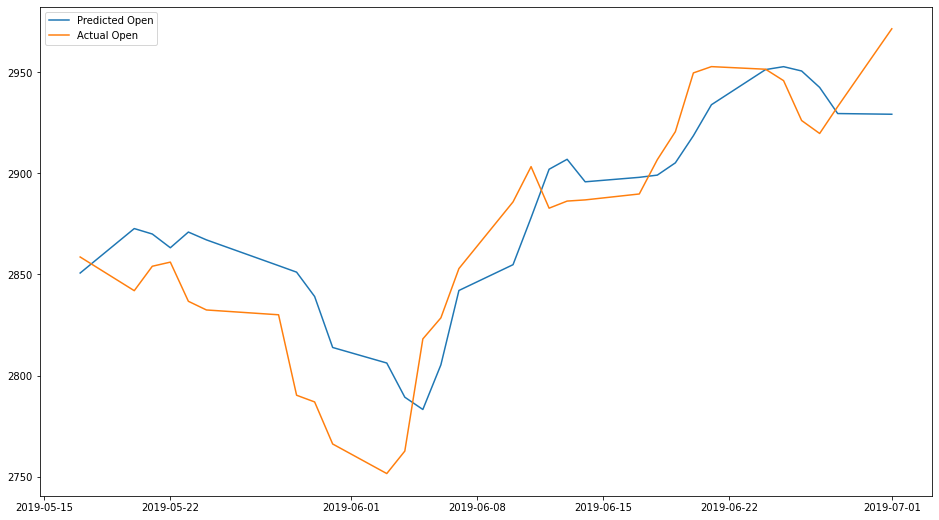

In [221]:
plt.figure(figsize = (16, 9))
plt.plot(df_open_predict)
plt.plot(test['Open'][2:])
plt.legend(["Predicted Open", "Actual Open"])
plt.show()


### Step 17: Repeat Steps 11-15 for "FilteredOpen" and "ZeroMeanFilteredOpen" 
Now that we've successfully done predictions using data from "Open", let's work on "FilteredOpen" and "ZeroMeanFilteredOpen" next.

Don't forget that you have to add the FilteredOpen mean to the predictions for ZeroMeanFilteredOpen.

In [ ]:
# Step 17a: Set up your model architecture for FilteredOpen, compile, and fit "FilteredOpen" data (Steps 11-12)

In [ ]:
# Step 17b: Transform, loop, transform, and reshape "FilteredOpen" test X data (Step 13)

# Step 17c: Make the predict method and inverse_transform call (Step 14)

# Step 17d: Create a DataFrame for your "FilteredOpen" prediction (Step 15)

In [ ]:
# Step 17e: Set up your model architecture for ZeroMeanFilteredOpen, compile, and fit "ZeroMeanFilteredOpen" data (Steps 11-12)

In [ ]:
# Step 17f: Transform, loop, transform, and reshape "ZeroMeanFilteredOpen" test X data (Step 13)

# Step 17g: Make the predict method and inverse_transform call (Step 14)

# Step 17h: Create a DataFrame for your "ZeroMeanFilteredOpen" prediction (Step 15)

# Step 17i: Add the FilteredOpen mean (Step 6a) from train DataFrame into all values (reverse the normalization)

In [222]:
# define model
model_FilteredOpen = Sequential()
model_FilteredOpen.add(LSTM(units = 50, return_sequences = True, input_shape = (2, 1)))
model_FilteredOpen.add(Dropout(0.3))
model_FilteredOpen.add(LSTM(units = 50))
model_FilteredOpen.add(Dropout(0.3))
model_FilteredOpen.add(Dense(units = 1))

model_FilteredOpen.compile(optimizer = 'adam', loss = 'mean_squared_error')

model_FilteredOpen.fit(arr_X_FilteredOpen, arr_y_FilteredOpen, epochs = 15, batch_size = 32)



Epoch 1/15
153/153 [==============================] - 4s 4ms/step - loss: 0.4967
Epoch 2/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0175
Epoch 3/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0157
Epoch 4/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0165
Epoch 5/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0145
Epoch 6/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0141
Epoch 7/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0146
Epoch 8/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0140
Epoch 9/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0139
Epoch 10/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0140
Epoch 11/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0127
Epoch 12/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0128
Epoch 13/15
153/153 [====

In [225]:
Open_FilteredOpen=scaler_FilteredOpen.transform(test[['FilteredOpen']])
X_FilteredOpen_test,y_FilteredOpen_test=split_sequence(Open_FilteredOpen)
arr_X_FilteredOpen_test = np.array(X_FilteredOpen_test)
arr_y_FilteredOpen_test = np.array(y_FilteredOpen_test)
predicted_FilteredOpen_price = model_FilteredOpen.predict(arr_X_FilteredOpen_test)
predicted_FilteredOpen_price = scaler_FilteredOpen.inverse_transform(predicted_FilteredOpen_price)
df_FilteredOpen_predict = pd.DataFrame(predicted_FilteredOpen_price, index = test.index[2:34])

In [226]:
# define model
model_ZeroMeanFilteredOpen = Sequential()
model_ZeroMeanFilteredOpen.add(LSTM(units = 50, return_sequences = True, input_shape = (2, 1)))
model_ZeroMeanFilteredOpen.add(Dropout(0.3))
model_ZeroMeanFilteredOpen.add(LSTM(units = 50))
model_ZeroMeanFilteredOpen.add(Dropout(0.3))
model_ZeroMeanFilteredOpen.add(Dense(units = 1))

model_ZeroMeanFilteredOpen.compile(optimizer = 'adam', loss = 'mean_squared_error')

model_ZeroMeanFilteredOpen.fit(arr_X_ZeroMeanFilteredOpen, arr_y_ZeroMeanFilteredOpen, epochs = 15, batch_size = 32)

Epoch 1/15
153/153 [==============================] - 4s 4ms/step - loss: 0.4534
Epoch 2/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0183
Epoch 3/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0181
Epoch 4/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0161
Epoch 5/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0156
Epoch 6/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0149
Epoch 7/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0138
Epoch 8/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0142
Epoch 9/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0153
Epoch 10/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0126
Epoch 11/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0134
Epoch 12/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0143
Epoch 13/15
153/153 [====

In [227]:
Open_ZeroMeanFilteredOpen=scaler_ZeroMeanFilteredOpen.transform(test[['ZeroMeanFilteredOpen']])
X_ZeroMeanFilteredOpen_test,y_ZeroMeanFilteredOpen_test=split_sequence(Open_ZeroMeanFilteredOpen)
arr_X_ZeroMeanFilteredOpen_test = np.array(X_ZeroMeanFilteredOpen_test)
arr_y_ZeroMeanFilteredOpen_test = np.array(y_ZeroMeanFilteredOpen_test)
predicted_ZeroMeanFilteredOpen_price = model_ZeroMeanFilteredOpen.predict(arr_X_ZeroMeanFilteredOpen_test)
predicted_ZeroMeanFilteredOpen_price = scaler_ZeroMeanFilteredOpen.inverse_transform(predicted_ZeroMeanFilteredOpen_price)
df_ZeroMeanFilteredOpen_predict = pd.DataFrame(predicted_ZeroMeanFilteredOpen_price, index = test.index[2:34])


In [230]:
df_ZeroMeanFilteredOpen_predict=df_ZeroMeanFilteredOpen_predict.add(mean_FilteredOpen) 

### Step 18: Plot all three predictions with the original test "Open"
Which predictions did the best? Let's find out by plotting all three sets of predictions on the same plot. 

If your ZeroMeanFilteredOpen plot is way lower than others, make sure you added the mean to undo the zero-mean normalization.

<details>
    <summary><font color = 'green'>SPOILERS! Click once for a look to compare our plot and yours</font></summary>
    <div>
        <img src = 'https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectFinancexLSTM/FinalPredictionPlots.png'>
    </div>
</details>

In [ ]:
# Step 18: Plot all predictions with the original test "Open"

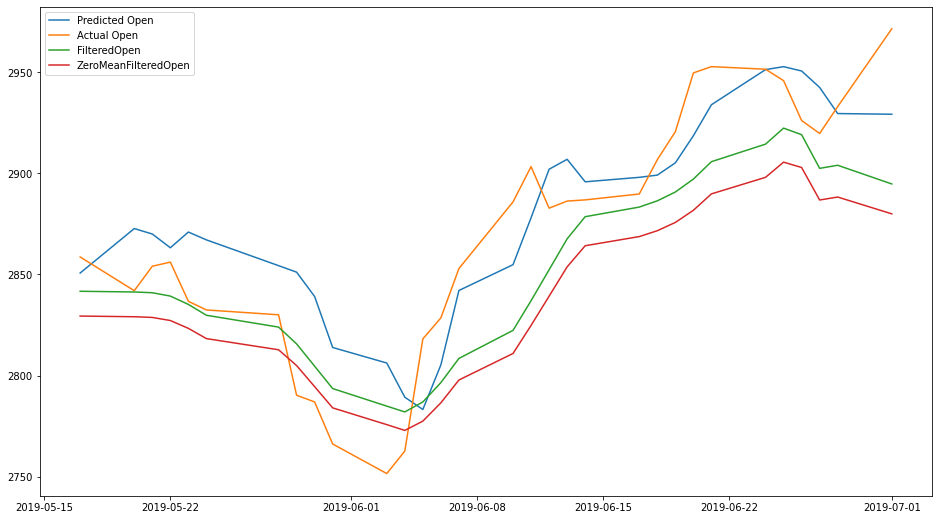

In [231]:
plt.figure(figsize = (16, 9))
plt.plot(df_open_predict)
plt.plot(test['Open'][2:])
plt.plot(df_FilteredOpen_predict)
plt.plot(df_ZeroMeanFilteredOpen_predict)
plt.legend(["Predicted Open", "Actual Open", "FilteredOpen","ZeroMeanFilteredOpen"])
plt.show()

### Step 19: Calculate the RMSE of the three predictions
Visually, we know which predictions performed best.

However, it's good to put a number on it as well. Let's calculate the RMSE of the predictions.

In [ ]:
# Step 19a: Print the RMSE of test 'Open' and 'Open' predictions

# Step 19b: Print the RMSE of test 'Open' and 'FilteredOpen' predictions

# Step 19c: Print the RMSE of test 'Open' and 'ZeroMeanFilteredOpen' predictions

In [236]:
mse_value_open=mean_squared_error(test['Open'][2:34],df_open_predict)
rmse_open=mse_value_open**0.5

mse_value_FilteredOpen=mean_squared_error(test['Open'][2:34],df_FilteredOpen_predict)
rmse_FilteredOpen=mse_value_FilteredOpen**0.5

mse_value_ZeroMeanFilteredOpen=mean_squared_error(test['Open'][2:34],df_ZeroMeanFilteredOpen_predict)
rmse_ZeroMeanFilteredOpen=mse_value_ZeroMeanFilteredOpen**0.5



print('The RMSE for Open and Open Predictions :%.2f' %(rmse_open))
print('The RMSE for Open and FilteredOpen Predictions :%.2f' %(rmse_FilteredOpen))
print('The RMSE for Open and Open ZeroMeanFilteredOpen :%.2f' %(rmse_ZeroMeanFilteredOpen))


The RMSE for Open and Open Predictions :28.77
The RMSE for Open and FilteredOpen Predictions :32.64
The RMSE for Open and Open ZeroMeanFilteredOpen :42.07


# The end
And that's the end! What a journey; you successfully performed classical and deep learning for S&P 500 stock prices.

To recap, you've:
1. Read research on stock pricing and retrieved the data
2. Investigated the ARIMA terms and performed ARIMA modelling
3. Used signal processing techniques to denoise stock data
4. Trained an LSTM model to predict stock pricing data

You have also answered the two questions that we wanted to ask at the start of this project.

Go on, give yourself a pat on the back. We hope this project series has give you more confidence in coding and deep learning. 

Whatever you learn here is but a tip of the iceberg, and launchpad for bigger and better things to come. 

If you're keen, here are some more things you can try:
- More datasets, e.g., HSI and DJI
- More modelling, e.g., more complex LSTM infrastructures

Come join us in our Telegram community over at https://bit.ly/UpLevelSG and our Facebook page at https://fb.com/UpLevelSG

<strong>Most importantly, UpLevel won't be what it is today without learners like yourself so help us grow by spreading the word and get more subscribers <font color = 'red'><3</font></strong>
